<a href="https://colab.research.google.com/github/MMoronto/ml-unstructured-data-projects/blob/master/Tile_based_classification_using_Sentinel_2_L1C_and_EuroSAT_data_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

This workflow explores the process of infering land use / classification from a pre-trained model based on the benchmark EuroSAT dataset. This note book contains notes I've taken as I work through the example workflows presented in the AI for Earth monitoring MOOC on Futurelearn.

This is the second of a two part practice module, the first part of this two part series explores the process of training a convolutional neural network based on EuroSAT benchmark data for land use/land cover classification while the second part explores the workflow for utilising the learned capabilities of our pre-trained model to infer land use / land cover classification on a Sentinel-2 level-1C tile image.   

## **Data**

The inference process utilizes the following data:

* a `Sentinel-2 level-1C file`, which is available in the following folder: ./S2_Tile_based_classification/01_input_data/S2_tile_4_inference.
The scene shows a coasteal part over Italy on March 31, 20121. The scene is used as input data for the pretrained model in order to infer land use/land cover classes.
* a `pretrained  model`, a `convolutional neural network` which has been trained based on EuroSAT  data, as a benchmark dataset for land use / land cover classifications.

## **Additional Resources**

* 3B - Tile-based classification with EuroSAT data - Training
* EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification
* EuroSAT data

## **Notebook Outline**

* 1 - Load a Sentinel-2 Level 1-C tile
* 2 - Resample all bands of a Seninel-2 Level 1-C tile to 10m spatial resolution
* 3 - Reorder the bands according to the order of the pretrained model
* 4 - Load the pretrained sequential convolutional neural network based on EuroSAT data
* 5 - Divide the Sentinel-2 L1C tile into  64x64 windows
* 6 - Infer land use classes
* 7 - Visualize the final classified image

**Import libraries**

In [1]:
## Begin S3FS import snippet ##
import os, sys
s3_home = os.getcwd()
try: sys.path.remove(s3_home) # Remove the S3 root from the path
except Exception: pass

current_dir = os.getcwd()

# os.chdir('/home/jovyan') # Temporarily move to another directory

# Begin imports #
import tensorflow as tf
from osgeo import gdal_array, osr, gdal
import glob
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import pyplot as pyplot
import matplotlib.colors
import warnings
warnings.filterwarnings("ignore")
# end imports #

os.chdir(current_dir) # go back to your previous directory

sys.path.append(s3_home) # restore the s3 root in the path

## end s3fs import snippet ##

In [2]:
## Begin S3FS Import Snippet ##
import os, sys
s3_home = os.getcwd()
try: sys.path.remove(s3_home) # Remove the S3 from the $path
except Exception: pass

# current_dir = os.getcwd()

# os.chdir('/home/jovyan') # Temporarily move to another directory

# Begin imports #
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from osgeo import gdal_array
from matplotlib import pyplot as pyplot
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import zipfile
# end imports #

# os.chdir(current_dir) # go back to your previous dir

# sys.path.append(s3_home) # restore the s3 root in the $path

## end s3fs import snippet ##



Define helper functions

from_folder_to_stack

In [3]:
import numpy as np

'''
function name: 
    from_folder_to_stack
description:
    This function transform the .SAFE file into three different arrays (10m, 20m and 60m).
Input:
    safe_path: the path of the .SAFE file;
    data_bands_20m: if True, the function computes stack using Sentinel2 band with 20m of pixel resolution (default=True);
    data_bands_60m: if True, the function computes stack using Sentinel2 band with 60m of pixel resolution (default=True);    
Output: 
    stack_10m: stack with the following S2L1C bands (B02,B03,B04,B08)
    stack_20m: stack with the following S2L1C bands (B05,B06,B07,B11,B12,B8A)
    stack_60m: stack with the following S2L1C bands (B01,B09,B10)
'''
def from_folder_to_stack(
        safe_path,
        data_bands_20m=True,
        data_bands_60m=True,
        ):        
    
    level_folder_name_list = glob.glob(safe_path + 'GRANULE/*') 
    level_folder_name = level_folder_name_list[0]
    
    if level_folder_name.find("L2A") < 0:
        safe_path = [level_folder_name + '/IMG_DATA/']
    else:
        safe_path_10m = level_folder_name + '/IMG_DATA/R10m/'
        safe_path = [safe_path_10m]
    
    text_files = []

    for i in range(0,len(safe_path)):
        print("[AI4EO_MOOC]_log: Loading .jp2 images in %s" % (safe_path[i]))
        text_files_tmp = [f for f in os.listdir(safe_path[i]) if f.endswith('.jp2')]
        text_files.append(text_files_tmp)
        
    lst_stack_60m=[]
    lst_code_60m =[]
    lst_stack_20m=[]
    lst_code_20m =[]
    lst_stack_10m=[]
    lst_code_10m =[]
    for i in range(0,len(safe_path)):        
        
        print("[AI4EO_MOOC]_log: Reading .jp2 files in %s" % (safe_path[i]))
        for name in range(0, len(text_files[i])):            
            text_files_tmp = text_files[i]               
            if data_bands_60m == True:
                cond_60m = ( (text_files_tmp[name].find("B01") > 0) or (text_files_tmp[name].find("B09") > 0) 
                            or (text_files_tmp[name].find("B10") > 0))
                if cond_60m:
                    print("[AI4EO_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
                    lst_stack_60m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
                    lst_code_60m.append(text_files_tmp[name][24:26])
                
            if data_bands_20m == True:                    
                cond_20m = (text_files_tmp[name].find("B05") > 0) or (text_files_tmp[name].find("B06") > 0) or (
                            text_files_tmp[name].find("B07") > 0) or (text_files_tmp[name].find("B11") > 0) or (
                                       text_files_tmp[name].find("B12") > 0) or (text_files_tmp[name].find("B8A") > 0)
                cond_60m_L2 = (text_files_tmp[name].find("B05_60m") < 0) and (text_files_tmp[name].find("B06_60m") < 0) and (
                            text_files_tmp[name].find("B07_60m") < 0) and (text_files_tmp[name].find("B11_60m") < 0) and (
                                       text_files_tmp[name].find("B12_60m") < 0) and (text_files_tmp[name].find("B8A_60m") < 0)
                cond_20m_tot = cond_20m and cond_60m_L2
                if cond_20m_tot:
                    print("[AI4EO_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
                    lst_stack_20m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
                    lst_code_20m.append(text_files_tmp[name][24:26])
            else:
                stack_20m = 0
                    
            cond_10m = (text_files_tmp[name].find("B02") > 0) or (text_files_tmp[name].find("B03") > 0) or (
                        text_files_tmp[name].find("B04") > 0) or (text_files_tmp[name].find("B08") > 0)
            cond_20m_L2 = (text_files_tmp[name].find("B02_20m") < 0) and (text_files_tmp[name].find("B03_20m") < 0) and (
                        text_files_tmp[name].find("B04_20m") < 0) and (text_files_tmp[name].find("B08_20m") < 0)
            cond_60m_L2 = (text_files_tmp[name].find("B02_60m") < 0) and(text_files_tmp[name].find("B03_60m") < 0) and(
                        text_files_tmp[name].find("B04_60m") < 0) and (text_files_tmp[name].find("B08_60m") < 0)
            cond_10m_tot = cond_10m and cond_20m_L2 and cond_60m_L2
            
            if cond_10m_tot:
                print("[AI4EO_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
                lst_stack_10m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
                lst_code_10m.append(text_files_tmp[name][24:26])
                 
    
    stack_10m=np.asarray(lst_stack_10m)
    sorted_list_10m = ['02','03','04','08']    
    print('[AI4EO_MOOC]_log: Sorting stack 10m...')
    stack_10m_final_sorted = stack_sort(stack_10m, lst_code_10m, sorted_list_10m)
    
    stack_20m=np.asarray(lst_stack_20m)
    sorted_list_20m = ['05','06','07','11','12','8A']
    print('[AI4EO_MOOC]_log: Sorting stack 20m...')
    stack_20m_final_sorted = stack_sort(stack_20m, lst_code_20m, sorted_list_20m)
    
    stack_60m=np.asarray(lst_stack_60m)
    sorted_list_60m = ['01','09','10']    
    print('[AI4EO_MOOC]_log: Sorting stack 60m...')
    stack_60m_final_sorted = stack_sort(stack_60m, lst_code_60m, sorted_list_60m)
                
    return stack_10m_final_sorted, stack_20m_final_sorted, stack_60m_final_sorted

stack_sort

In [4]:
def stack_sort(stack_in, lst_code, sorted_list):
  b, r, c = stack_in.shape
  stack_sorted = np.zeros((r,c,b), dtype=np.uint16)

  len_list_bands = len(lst_code)

  c = np.zeros((len_list_bands), dtype=np.uint8)
  count = 0
  count_sort = 0
  while count_sort != len_list_bands:
    if lst_code[count] == sorted_list[count_sort]:
      c[count_sort] = count
      count_sort = count_sort + 1
      count = 0
    else:
      count = count + 1
    print('[AI4EO_MOOC]_log: sorted list:', sorted_list)
    print('[AI4EO_MOOC]_log: bands:', c)
    for i in range(0, len_list_bands):
        stack_sorted[:,:,i]=stack_in[c[i],:,:]
    
    return stack_sorted

resample_3d

In [5]:
'''
function name:
  resample_3d
description:
  wrapper of ndimage zoom. Bilinear interpolation for resampling array
input:
  stack: array to be resampled;
  row10m: the expected row;
  col10m: the expected col;
  rate: the rate of the transformation;
output:
  stack_10m: resampled array
'''
def resample_3d(
        stack,
        row10m,
        col10m,
        rate):
    row, col, bands = stack.shape
    print("[AI4EO_MOOC]_log: Array shape (%d,%d,%d)" % (row, col, bands))

    stack_10m = np.zeros((row10m, col10m, bands),dtype=np.uint16)
    print("[AI4EO_MOOC]_log: Resize array bands from (%d,%d,%d) to (%d,%d,%d)" % (
        row, col, bands, row10m, col10m, bands))
    
    for i in range(0, bands):
      stack_10m[:, :, i] = ndimage.zoom(stack[:, :,i], rate)

    del (stack)

    return stack_10m

sentinel2_format

In [6]:
'''
function name:
  sentinel2_format
description:
  This function transforms the multistack into sentinel2 format arrays with bands in the right positions for our AI model.
input:
  total_stack: array that is the concatenation of stack10, stack_20mTo10m and stack_60mTo10m.
output:
  sentinel2: sentinel2 format array
'''
def sentinel2_format(
        total_stack):
  
    row_tot, col_tot, bands_tot = total_stack.shape
    sentinel2 = np.zeros((row_tot, col_tot, bands_tot),dtype=np.uint16)

    print("[AI4EO_MOOC]_log: Creating a total stack with following list of bands:")
    print("[AI4EO_MOOC]_log: Band 1 - Coastal aerosol")
    print("[AI4EO_MOOC]_log: Band 2 - Blue")
    print("[AI4EO_MOOC]_log: Band 3 - Green")
    print("[AI4EO_MOOC]_log: Band 4 - Red")
    print("[AI4EO_MOOC]_log: Band 5 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 6 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 7 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 8 - NIR")
    print("[AI4EO_MOOC]_log: Band 8A - Narrow NIR")
    print("[AI4EO_MOOC]_log: Band 9 - Water vapour")
    print("[AI4EO_MOOC]_log: Band 10 - SWIR - Cirrus")
    print("[AI4EO_MOOC]_log: Band 11 - SWIR")
    print("[AI4EO_MOOC]_log: Band 12 - SWIR")

    sentinel2[:, :, 0] = total_stack[:, :, 10]
    sentinel2[:, :, 1] = total_stack[:, :, 0]
    sentinel2[:, :, 2] = total_stack[:, :, 1]
    sentinel2[:, :, 3] = total_stack[:, :, 2]
    sentinel2[:, :, 4] = total_stack[:, :, 4]
    sentinel2[:, :, 5] = total_stack[:, :, 5]
    sentinel2[:, :, 6] = total_stack[:, :, 6]
    sentinel2[:, :, 7] = total_stack[:, :, 3]
    sentinel2[:, :, 8] = total_stack[:, :, 9]
    sentinel2[:, :, 9] = total_stack[:, :, 11]
    sentinel2[:, :, 10] = total_stack[:, :, 12]
    sentinel2[:, :, 11] = total_stack[:, :, 7]
    sentinel2[:, :, 12] = total_stack[:, :, 8]

sliding

In [7]:
'''
Function_name:
  sliding
description:
input:
  shape: the target shape
  window_size: the shape of the window
  step-size:
  fixed
output:
  windows:
'''

def sliding(shape, window_size, step_size=None, fixed=True):
    
    h, w = shape
    if step_size:
        h_step = step_size
        w_step = step_size
    else:
        h_step = window_size
        w_step = window_size
        
    h_wind = window_size
    w_wind = window_size
    windows = []
    for y in range(0, h, h_step):
        for x in range(0, w, w_step):
            h_min = min(h_wind, h - y)
            w_min = min(w_wind, w - x)
            if fixed:
                if h_min < h_wind or w_min < w_wind:
                    continue
            window = (x, y, w_min, h_min)
            windows.append(window)

    return windows

# **1. Load a Sentinel-2 Level-1C tile**

In the first step, we lod the input data for the inference process. The input data is a Sentinel2 Level-1C tile which shall be classified with the help of the pre-trained model.

Let us define the Python dictionary which holds information about where the Sentinel-2 Level-1C data is stored. Next we'll define `main_path`, `sentinel2_safe_name` and `sentinel2_safe_path`.

In [8]:
data_input = {}
data_input['main_path'] ='/content/drive/MyDrive/Land Classification/S2_Tile_based_classification/'

data_input['sentinel2_safe_name'] = 'S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/'
data_input['sentinel2_safe_path'] = data_input['main_path']+'01_Input_data/S2_tile_4_inference/' + data_input['sentinel2_safe_name']

The next step makes use of the `function from_folder_to_stack()`. The functions transforms the Sentinel-2 Level-1C file which is disseminated in the `.SAFE` format into three different arrays, each combining the bands with the same spatial resolution. Sentinel-2 samples 13 spectral bands, which have three different resolutions:`10m, 20m and 60m`.

The result of the function are three stacked arrays:

* `stack_10m`: stack combining bands with 10m spatial resolution `(B02, B03, B04, B08)
* `stack_20m`: stack combining bands with 20m spatial resolution `(B05, B06, B07, B11, B12, B8A)
* `stack_60m`: stack combining bands with 60m spatial resolution `(B01, B09, B10)

In [9]:
import numpy as np
safe_path = data_input['sentinel2_safe_path']
stack_10m, stack_20m, stack_60m = from_folder_to_stack(safe_path)

[AI4EO_MOOC]_log: Loading .jp2 images in /content/drive/MyDrive/Land Classification/S2_Tile_based_classification/01_Input_data/S2_tile_4_inference/S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/GRANULE/L1C_T33TTG_A030149_20210331T100404/IMG_DATA/
[AI4EO_MOOC]_log: Reading .jp2 files in /content/drive/MyDrive/Land Classification/S2_Tile_based_classification/01_Input_data/S2_tile_4_inference/S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/GRANULE/L1C_T33TTG_A030149_20210331T100404/IMG_DATA/
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B10.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B09.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B01.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B05.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B07.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B06.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B11.jp2


On inspecting the dimensions of the three stacked arrays, we 'll notice that the stack combining bands with 10m resolution consists of 4 bands. The one combining bands with 20m resolution consists of 6 bands and the one combining bands with 60m resolution consists of 3 bands.

In [10]:
print(stack_10m.shape)
print(stack_20m.shape)
print(stack_60m.shape)

(10980, 10980, 4)
(5490, 5490, 6)
(1830, 1830, 3)


#**2. Resample all bands of a Sentinel-2 Level 1-C tile to 10m spatial resolution**

In the next step we resample the arrays containing bands with 20m and 60m resolution. You can use the function `resample_3d()` to achive this. The function takes the following keyword arguments:

* `stack`: array to be resampled to 10m
* `row10m`: number of rows of the 10m resolution array
* `col10m`: number of columns of the 10m resolution array
* `rate`: to which rate the input stack shall be resampled

We have to apply the function to both array stacks, `stack_20m` and `stack_60m`. This results in all three stacks having the same spatial resolution of 10m.

In [11]:
n_row, n_col, b10 = stack_10m.shape

print('[AI4EO_MOOC]_log: Resampling stack with 20 m pixel size...')
stack_20mTo10m = resample_3d(stack = stack_20m,
                             row10m = n_row,
                             col10m = n_col,
                             rate= 2)

print('[AI4EO_MOOC]_log: Resampling stack with 60 m pixel size...')
stack_60mTo10m = resample_3d(stack = stack_60m,
                             row10m = n_row,
                             col10m = n_col,
                             rate= 6)

print(stack_20mTo10m.shape)
print(stack_60mTo10m.shape)

[AI4EO_MOOC]_log: Resampling stack with 20 m pixel size...
[AI4EO_MOOC]_log: Array shape (5490,5490,6)
[AI4EO_MOOC]_log: Resize array bands from (5490,5490,6) to (10980,10980,6)
[AI4EO_MOOC]_log: Resampling stack with 60 m pixel size...
[AI4EO_MOOC]_log: Array shape (1830,1830,3)
[AI4EO_MOOC]_log: Resize array bands from (1830,1830,3) to (10980,10980,3)
(10980, 10980, 6)
(10980, 10980, 3)


#**3. Reorder the bands according to the order of the pretrained model**

The three array stack now have the same spatial resolution. In a next step, we'll concatenate them with the numpy function `concatenate`. We want to concatenate them on the band dimensions (axis=2). The result is one array with a spatial resolution of 10m and 13 bands.

In [12]:
print('[AI4EO_MOOC]_log: Creating multistack with 10-20-60 m pixel size')

total_stack=np.concatenate((stack_10m, stack_20mTo10m, stack_60mTo10m),
                           axis=2)

total_stack.shape

[AI4EO_MOOC]_log: Creating multistack with 10-20-60 m pixel size


(10980, 10980, 13)

We can now plot the reflectance for each band for one pixel with matplotlib's `plot()` function.

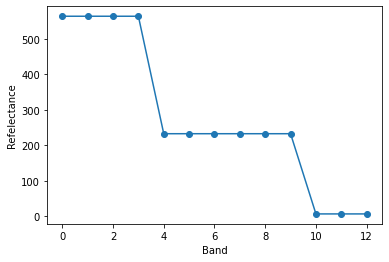

In [13]:
plt.ylabel("Refelectance")
plt.xlabel("Band")
plt.plot(total_stack[200,200,:],'-o')

The next step involves arranging the Sentinel-2 bands and bringing them to the correct position for the pre-trained model. The function `sentinel2_format` helps bring the bands into the correct order for the model. You want to arrange the bands into the following order:    

* `Band 1 - Coastal aerosol` <-- `S2L1 Band 10`

* `Band 2 - Blue` <-- `S2L1 Band 0`

* `Band 3 - Green` <-- `S2L1 Band 1`

* `Band 4 - Red` <-- `S2L1 Band 10`

* `Band 5 - Vegetation red edge` <-- `S2L1 Band 4`

* `Band 6 - Vegetation red edge` <-- `S2L1 Band 5`

* `Band 7 - Vegetation red edge` <-- `S2L1 Band 6`

* `Band 8 - NIR` <-- `S2L1 Band 3`

* `Band 8A - Narrow NIR` <-- `S2L1 Band 9`

* `Band 9 -  Water Vapor` <-- `S2L1 Band 11`

* `Band 10 - SWIR - Cirrus` <-- `S2L1 Band 12`

* `Band 11 - SWIR` <-- `S2L1 Band 7`

* `Band 12 - SWIR` <-- `S2L1 Band 8`

In [14]:
s2_arr = sentinel2_format(total_stack)

[AI4EO_MOOC]_log: Creating a total stack with following list of bands:
[AI4EO_MOOC]_log: Band 1 - Coastal aerosol
[AI4EO_MOOC]_log: Band 2 - Blue
[AI4EO_MOOC]_log: Band 3 - Green
[AI4EO_MOOC]_log: Band 4 - Red
[AI4EO_MOOC]_log: Band 5 - Vegetation red edge
[AI4EO_MOOC]_log: Band 6 - Vegetation red edge
[AI4EO_MOOC]_log: Band 7 - Vegetation red edge
[AI4EO_MOOC]_log: Band 8 - NIR
[AI4EO_MOOC]_log: Band 8A - Narrow NIR
[AI4EO_MOOC]_log: Band 9 - Water vapour
[AI4EO_MOOC]_log: Band 10 - SWIR - Cirrus
[AI4EO_MOOC]_log: Band 11 - SWIR
[AI4EO_MOOC]_log: Band 12 - SWIR


Now, we can plot the reflectance for each of the bands for the same pixel as above and we can now easily identify it as a water pixel.

TypeError: ignored

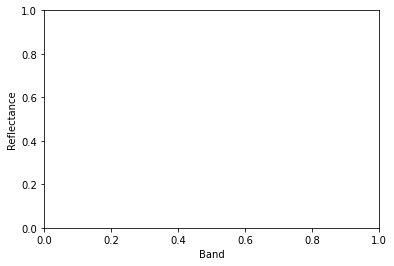

In [15]:
plt.ylabel("Reflectance")
plt.xlabel("Band")
plt.plot(s2_arr[200,200,:],'-o')

Plot the reflectances of and see higher reflectances over bands 6 to 8, which are the channels for vegetation.

TypeError: ignored

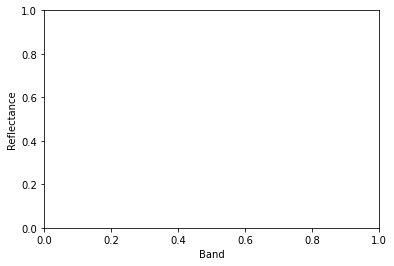

In [16]:
plt.ylabel("Reflectance")
plt.xlabel('Band')
plt.plot(s2_arr[10000,10000,:],'-o')

#**4. Load the pretrained sequential convolutional neural network based on EuroSAT data**

Next, you can load the pre-trained model which has been trained in the notebook 3B_tile-based_classification_with_EuroSAT_data_training. The function `load_model()` from the class `keras.models` allows you to load a model in the Keras format `H5`. With `model.summary()` you can get tabular overview of the model architecture. 


In [17]:
data_input['pre_trained_model_name'] = 'keras_sentinel2_classification_trained_model_e50_9190.h5'
data_input['pre_trained_model_path'] = data_input['main_path'] + '02_pretrained_model/'

model = tf.keras.models.load_model(data_input['pre_trained_model_path'] + data_input['pre_trained_model_name'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        3776      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 32)        0         
                                                      

#**5. Divide the Sentinel-2 L1C tile into  64x64 windows**

SInce the Convolutional Neural Network has been trained on EuroSAT benchmark data, which have a dimension of `[13, 64, 64]`, the trained model can only predict on `64x64 pixel` subsets (so-called chips).

We can apply the function `sliding()`, which divides the Sentinel-2 image with a dimension of `10980 x 10980 pixels` into multiple subsets with a size of `64 x 64 pixels`.

In [20]:
print('[AI4EO_MOOC]_log: Divide all images into windows for the inference step')

target_shape = (s2_arr.shape[0], s2_arr.shape[1])
windows = sliding(target_shape, 64, fixed=True)

[AI4EO_MOOC]_log: Divide all images into windows for the inference step


AttributeError: ignored

#**6. Infer land use classes**

The next step is the inference process. In this step we apply the loaded model and predict the probabilities of each of the ten land use classes for each pixel. Let's define some variables that help us specify the parameters for the inference process.  Let us define `batch_size=10`, which specifies the number of parallel computations and also reduces the number of iterations during the inference process by a factor of 10.

In [19]:
windows_ = iter(windows)
windows_class = iter(windows)

batch_size = 10
total_chips = len(windows)
num_steps = int(total_chips / batch_size)

NameError: ignored

In the next step, we go through each `64 x 64 pixel` window(chip), retrieve the channel information of the Sentinel-2 image and predict the land cover classes for each chip with the function `model.predict()`. The prediction results return the probability of each land use class for each pixel. With numpy function `argmax()`, we can select the class with the highest predicted probability.

The last step involves graduall;y building up the final image `img_classes` with the predicted land use  classes and a dimension of `(10980 x 10980)`, based on the `64 x 64 pixel` windows.

In [ ]:
print('[AI4EO_MOOC]_log: Inference step...')

img_classes = np.zeros((total_stack.shape[0], total_stack.shape[1]), dtype=np.uint8)

predictions = []
progbar = tf.keras.utils.Progbar(num_steps)

for b in range(num_steps):
    chips = np.empty([batch_size, 64, 64, 13])
    for k in range(batch_size):
        ymin, xmin, xmax, ymax = next(windows_)
        chips[k] = s2_arr[xmin:xmin+xmax, ymin:ymin+ymax, :]

    preds = model.predict(chips)
    predictions.append(np.argmax(preds, axis=-1))
    for i in range(0, batch_size):
        ymin_cl. xmin_cl, xmax_cl, ymax_cl = next(windows_class)
        img_classes[xmin_cl:xmin_cl+xmax_cl, ymin_cl:ymin_cl+ymax_cl] = predictions[b][i]
    progbar.update(b + 1)

#**7. Visualize the final classified image**

In this final step, we'll visualize the classified image after running the inference on our images. We can use matplotlib's function `imshow()` to visualize the predicted array `img_classes`. For readability, we can define class labels (`label`) and a customized color scale.

In [ ]:
label=['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
       'Pasture','PermanentCrop','Residential','River','SeaLake']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", 
    ["linen","darkgreen","lime","grey","k",
     "olive","darkgoldenrod","lightgrey","azure","lightblue"])

plt.figure(figsize=(10,10))
plt.imshow(img_classes, cmap=cmap)
cbar=plt.colorbar()
cbar.ax.set_yticklabels(label)
plt.show()